#Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D,Conv1DTranspose,Concatenate,Input
import numpy as np
import IPython.display
import glob
from tqdm.notebook import tqdm
import librosa.display
import matplotlib.pyplot as plt

#Extracting Data

In [2]:
!gdown --id 1kDXN8KqL2dvMqDt4q8kU7aI7NnJgnrTi

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1kDXN8KqL2dvMqDt4q8kU7aI7NnJgnrTi
To: /content/datset.zip
100% 614M/614M [00:05<00:00, 110MB/s]


In [3]:
! unzip '/content/datset.zip'

Archive:  /content/datset.zip
   creating: content/dataset/
   creating: content/dataset/noisy_pieces/
  inflating: content/dataset/noisy_pieces/noisy292.wav  
  inflating: content/dataset/noisy_pieces/noisy139.wav  
  inflating: content/dataset/noisy_pieces/noisy161.wav  
  inflating: content/dataset/noisy_pieces/noisy451.wav  
  inflating: content/dataset/noisy_pieces/noisy900.wav  
  inflating: content/dataset/noisy_pieces/noisy338.wav  
  inflating: content/dataset/noisy_pieces/noisy537.wav  
  inflating: content/dataset/noisy_pieces/noisy734.wav  
  inflating: content/dataset/noisy_pieces/noisy981.wav  
  inflating: content/dataset/noisy_pieces/noisy243.wav  
  inflating: content/dataset/noisy_pieces/noisy849.wav  
  inflating: content/dataset/noisy_pieces/noisy769.wav  
  inflating: content/dataset/noisy_pieces/noisy657.wav  
  inflating: content/dataset/noisy_pieces/noisy601.wav  
  inflating: content/dataset/noisy_pieces/noisy396.wav  
  inflating: content/dataset/noisy_pieces/

#Load the Data

In [4]:
clean_sounds = sorted(glob.glob('/content/content/dataset/clean_pieces/*'))
noisy_sounds = sorted(glob.glob('/content/content/dataset/noisy_pieces/*'))

clean_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(clean_sounds[0]),desired_channels=1)
for i in tqdm(clean_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  clean_sounds_list = tf.concat((clean_sounds_list,so),0)

noisy_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(noisy_sounds[0]),desired_channels=1)
for i in tqdm(noisy_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  noisy_sounds_list = tf.concat((noisy_sounds_list,so),0)

clean_sounds_list.shape,noisy_sounds_list.shape

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

(TensorShape([198450000, 1]), TensorShape([198450000, 1]))

In [5]:
batching_size = 12000

clean_train,noisy_train = [],[]

for i in tqdm(range(0,clean_sounds_list.shape[0]-batching_size,batching_size)):
  clean_train.append(clean_sounds_list[i:i+batching_size])
  noisy_train.append(noisy_sounds_list[i:i+batching_size])

clean_train = tf.stack(clean_train)
noisy_train = tf.stack(noisy_train)

clean_train.shape,noisy_train.shape

  0%|          | 0/16537 [00:00<?, ?it/s]

(TensorShape([16537, 12000, 1]), TensorShape([16537, 12000, 1]))

# Create a tf.data.Dataset

In [6]:
def get_dataset(x_train,y_train):
  dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
  dataset = dataset.shuffle(100).batch(64,drop_remainder=True)
  return dataset

In [7]:
train_dataset = get_dataset(noisy_train[:40000],clean_train[:40000])
test_dataset = get_dataset(noisy_train[40000:],clean_train[40000:])

#Reviewing Sample Waveform

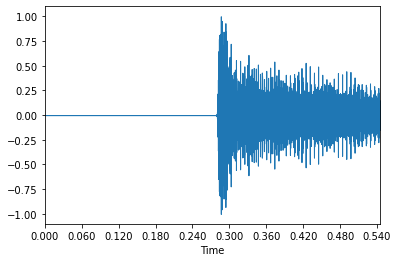

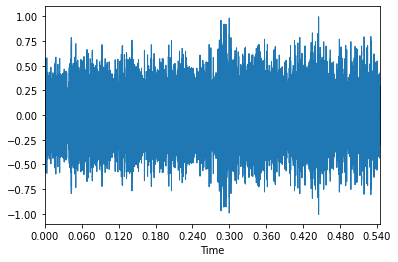

In [8]:
librosa.display.waveplot(np.squeeze(clean_train[5].numpy(),axis=-1))
plt.show()
librosa.display.waveplot(np.squeeze(noisy_train[5].numpy(),axis=-1))
plt.show()

#Creating the Model

In [9]:
inp = Input(shape=(batching_size,1))
c1 = Conv1D(2,32,2,'same',activation='relu')(inp)
c2 = Conv1D(4,32,2,'same',activation='relu')(c1)
c3 = Conv1D(8,32,2,'same',activation='relu')(c2)
c4 = Conv1D(16,32,2,'same',activation='relu')(c3)
c5 = Conv1D(32,32,2,'same',activation='relu')(c4)

dc1 = Conv1DTranspose(32,32,1,padding='same')(c5)
conc = Concatenate()([c5,dc1])
dc2 = Conv1DTranspose(16,32,2,padding='same')(conc)
conc = Concatenate()([c4,dc2])
dc3 = Conv1DTranspose(8,32,2,padding='same')(conc)
conc = Concatenate()([c3,dc3])
dc4 = Conv1DTranspose(4,32,2,padding='same')(conc)
conc = Concatenate()([c2,dc4])
dc5 = Conv1DTranspose(2,32,2,padding='same')(conc)
conc = Concatenate()([c1,dc5])
dc6 = Conv1DTranspose(1,32,2,padding='same')(conc)
conc = Concatenate()([inp,dc6])
dc7 = Conv1DTranspose(1,32,1,padding='same',activation='linear')(conc)
model = tf.keras.models.Model(inp,dc7)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 6000, 2)      66          ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 3000, 4)      260         ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 1500, 8)      1032        ['conv1d_1[0][0]']               
                                                                                              

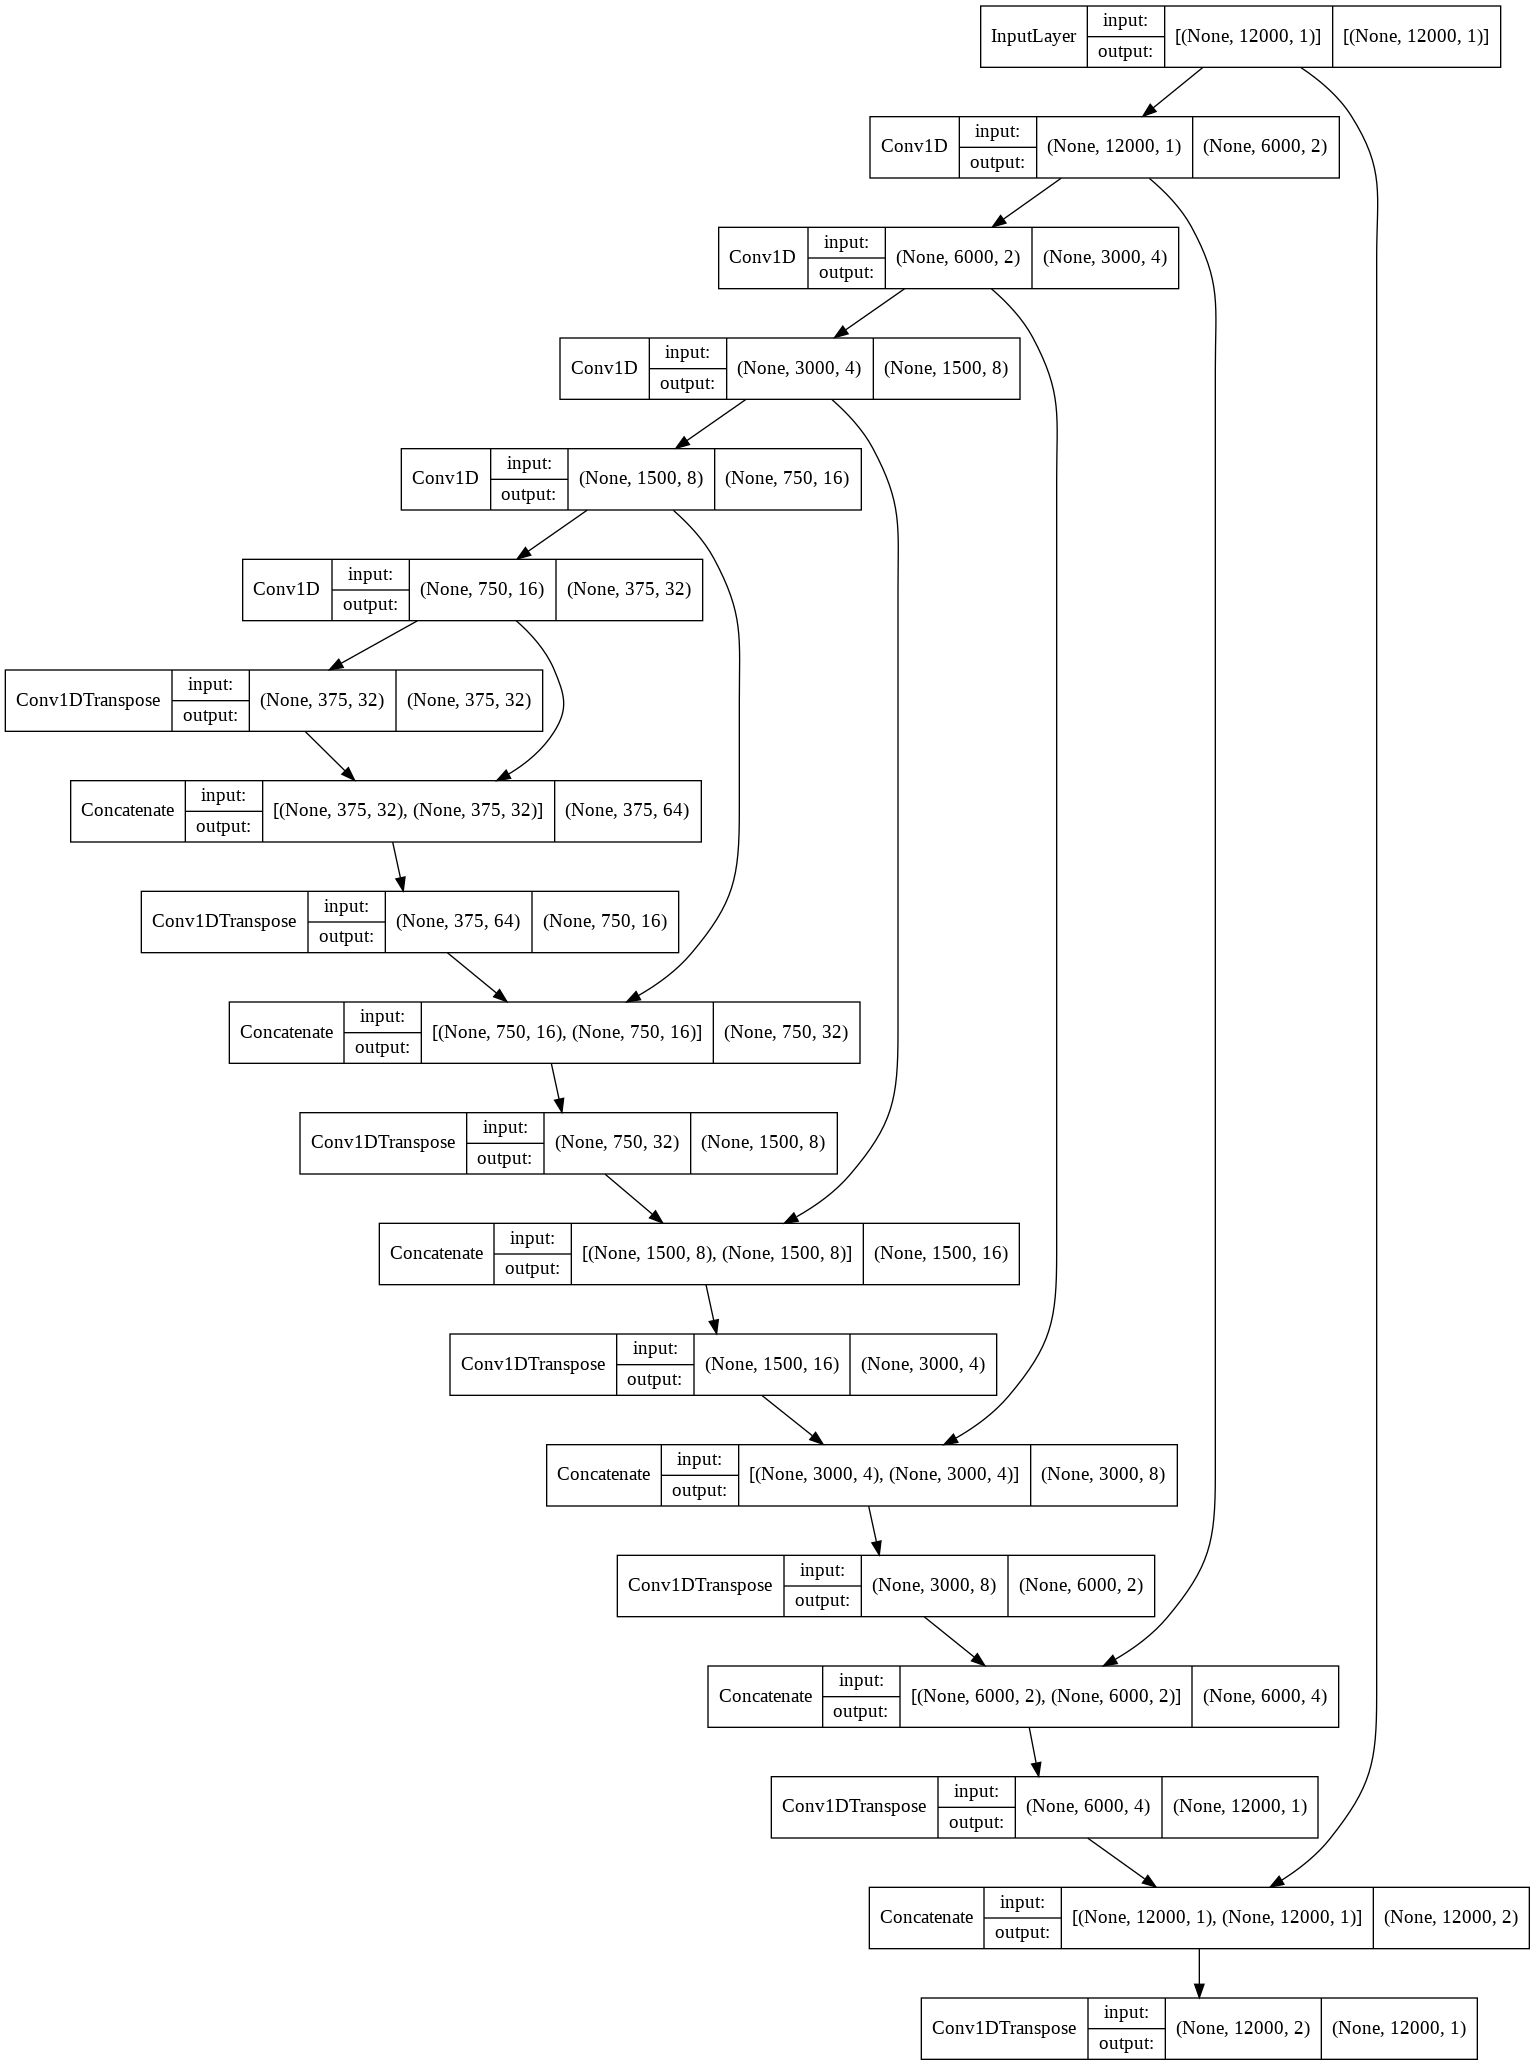

In [10]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=False)

#Training

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.002),loss=tf.keras.losses.MeanAbsoluteError())
history = model.fit(train_dataset,epochs=20)

Epoch 1/20
258/258 [==============================] - 21s 32ms/step - loss: 0.0444
Epoch 2/20
258/258 [==============================] - 10s 38ms/step - loss: 0.0359
Epoch 3/20
258/258 [==============================] - 12s 45ms/step - loss: 0.0326
Epoch 4/20
258/258 [==============================] - 12s 45ms/step - loss: 0.0316
Epoch 5/20
258/258 [==============================] - 9s 36ms/step - loss: 0.0294
Epoch 6/20
258/258 [==============================] - 9s 36ms/step - loss: 0.0292
Epoch 7/20
258/258 [==============================] - 10s 37ms/step - loss: 0.0273
Epoch 8/20
258/258 [==============================] - 10s 37ms/step - loss: 0.0272
Epoch 9/20
258/258 [==============================] - 10s 37ms/step - loss: 0.0266
Epoch 10/20
258/258 [==============================] - 10s 40ms/step - loss: 0.0260
Epoch 11/20
258/258 [==============================] - 10s 39ms/step - loss: 0.0257
Epoch 12/20
258/258 [==============================] - 10s 39ms/step - loss: 0.0250
Epo

#Testing Samples

In [12]:
from IPython.display import Audio
Audio(np.squeeze(noisy_train[10000].numpy()),rate=16000)

In [13]:
Audio(tf.squeeze(model.predict(tf.expand_dims(tf.expand_dims(noisy_train[10000],-1),0))),rate=16000)

In [14]:
temp = model.predict(tf.expand_dims(tf.expand_dims(noisy_train[22],-1),0))
for i in noisy_train[23:38]:
  pred = model.predict(tf.expand_dims(tf.expand_dims(i,-1),0))
  temp = np.concatenate([temp,pred],0)

In [15]:
temp.shape

(16, 12000, 1)

In [16]:
arr = np.reshape(temp,(192000,1))

In [17]:
Audio(tf.squeeze(arr),rate=16000)

In [42]:
fav, sample_rate = tf.audio.decode_wav(tf.io.read_file(noisy_sounds[1]),desired_channels=1)

In [43]:
fav.shape

TensorShape([198450, 1])

In [44]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [45]:
arr = []
for i in tqdm(range(0,fav.shape[0]-batching_size,batching_size)):
  arr.append(fav[i:i+batching_size])

arr = tf.stack(arr)

arr.shape

  0%|          | 0/16 [00:00<?, ?it/s]

TensorShape([16, 12000, 1])

In [46]:
temp = model.predict(tf.expand_dims(tf.expand_dims(arr[1],-1),0))
for i in arr[1:]:
  pred = model.predict(tf.expand_dims(tf.expand_dims(i,-1),0))
  temp = np.concatenate([temp,pred],0)

In [47]:
arr = np.reshape(temp,(192000,1))

In [48]:
Audio(tf.squeeze(arr),rate=16000)

In [49]:
noisy, sample_rate = tf.audio.decode_wav(tf.io.read_file(noisy_sounds[1]),desired_channels=1)

In [50]:
Audio(tf.squeeze(noisy),rate=16000)

In [51]:
clean, sample_rate = tf.audio.decode_wav(tf.io.read_file(clean_sounds[1]),desired_channels=1)

In [52]:
Audio(tf.squeeze(clean),rate=16000)

In [ ]:
model.evaluate(test_dataset)

In [53]:
model.save('NoiseSuppressionModel.h5')

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [56]:
!cp -r "NoiseSuppressionModel.h5" "/content/drive/MyDrive/NoiseSuppressionModel.h5"

# Inference

Handling different sized audio inputs can be solved by overlapping prediction frames and removing the intersection part from the final waveform

In [ ]:
def get_audio(path):
  audio,_ = tf.audio.decode_wav(tf.io.read_file(path),1)
  return audio

In [ ]:
def inference_preprocess(path):
  audio = get_audio(path)
  audio_len = audio.shape[0]
  batches = []
  for i in range(0,audio_len-batching_size,batching_size):
    batches.append(audio[i:i+batching_size])

  batches.append(audio[-batching_size:])
  diff = audio_len - (i + batching_size)
  return tf.stack(batches), diff

In [ ]:
def predict(path):
  test_data,diff = inference_preprocess(path)
  predictions = model.predict(test_data)
  final_op = tf.reshape(predictions[:-1],((predictions.shape[0]-1)*predictions.shape[1],1))
  final_op = tf.concat((final_op,predictions[-1][-diff:]),axis=0)
  return final_op

In [ ]:
Audio(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1),rate=16000)

In [ ]:
Audio(tf.squeeze(predict(noisy_sounds[4])),rate=16000)

In [ ]:
%%timeit
tf.squeeze(predict(noisy_sounds[3]))

In [ ]:
librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1))
librosa.display.waveplot(np.squeeze(predict(noisy_sounds[4])))

#Quantization and TFLite Conversion

In [ ]:
lite_model = tf.lite.TFLiteConverter.from_keras_model(model)
lite_model.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = lite_model.convert()

In [ ]:
with open('TFLiteModel.tflite','wb') as f:
  f.write(tflite_model_quant)

#TFLite Inference

In [ ]:
interpreter = tf.lite.Interpreter(model_path='/content/TFLiteModel.tflite')
interpreter.allocate_tensors()

In [ ]:
def predict_tflite(path):
  test_audio,diff = inference_preprocess(path)
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  preds = []
  for i in test_audio:
    interpreter.set_tensor(input_index, tf.expand_dims(i,0))
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_index)
    preds.append(predictions)

  predictions = tf.squeeze(tf.stack(preds,axis=1))
  final_op = tf.reshape(predictions[:-1],((predictions.shape[0]-1)*predictions.shape[1],1))
  final_op = tf.concat((tf.squeeze(final_op),predictions[-1][-diff:]),axis=0)
  return final_op

In [ ]:
# Original Noisy Audio
Audio(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1),rate=16000)

In [ ]:
# Clean Audio
Audio(np.squeeze(get_audio(clean_sounds[4]).numpy(),-1),rate=16000)

In [ ]:
# Output Audio
Audio(predict_tflite(noisy_sounds[4]),rate=16000)

In [ ]:
%%timeit
predict_tflite(noisy_sounds[3])

In [ ]:
librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1))
librosa.display.waveplot(predict_tflite(noisy_sounds[4]).numpy())